# Классификация текстов в российских социальных сетях - задача многоклассовой классификации

Сообщества ВКонтакте могут принадлежать к одной из нескольких предопределенных категорий. Но даже среди спортивных сообществ существует довольно сильное разделение по тематике! Одни и те же авторы могут писать только об одном виде спорта или сразу о большом количестве.
На основе заданного набора сообщений определите тему - какой вид спорта обсуждается в выбранном сообществе?

Классификация текстов в российских социальных сетях может быть полезна для широкого круга пользователей, от обычных пользователей до маркетологов, аналитиков и администраторов платформ.

## О наборе данных

| Признак на английском | Перевод на русский |
|---|---|
| VK group id | идентификатор группы во ВКонтакте |
| text | текст сообщения в сообществе |

**Target variable (целевая переменная): category name: athletics, autosport,basketball, boardgames, esport, extreme, football, hockey, martial arts, motosport, tennis, volleyball, winter_sport (название категории: легкая атлетика, автоспорт, баскетбол, настольные игры, киберспорт, экстрим, футбол, хоккей, боевые искусства, мотоспорт, теннис, волейбол, зимний спорт)**

# Mounting a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from string import punctuation

stop_words = set(stopwords.words('russian'))
punctuation_set = set(punctuation)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import joblib
# Сохранение лучшей модели по указанному пути
model_path = '/content/drive/MyDrive/Datasets/neigh_model.pkl'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the Dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/train_social_media.csv')
data

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


# Exploratory Data Analysis (EDA)

In [ ]:
data.head(10)

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
5,780575952,boardgames,Северные территории на границе королевства Нал...
6,741108447,hockey,Рашит Давыдов поделился деталями общения с гол...
7,642761184,esport,Какой т3 игрок на данный момент перспективнее ...
8,418053478,athletics,7 августа в Москве в Измайловском парке состои...
9,748701390,motosport,Ребята подскажите диску капец или нет Таких тр...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38740 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       38740 non-null  int64 
 1   category  38740 non-null  object
 2   text      38740 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.1+ KB


В наборе данных пропусков нет

In [ ]:
data.describe()

,oid
count,3.874000e+04
mean,5.022681e+08
std,2.829376e+08
min,1.659400e+04
25%,2.670941e+08
50%,5.064389e+08
75%,7.423103e+08
max,9.997113e+08


In [ ]:
data.describe(include="object")

,category,text
count,38740,38740
unique,13,35774
top,autosport,За кроссовками в Баскетбольный магазин Ghetto ...
freq,3160,163


In [ ]:
data.columns

Index(['oid', 'category', 'text'], dtype='object')

В наборе данных присутствуют дубликаты в столбце text - удалим их

In [ ]:
data = data.drop_duplicates(['text'])
data

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


In [ ]:
data.describe(include="object")

,category,text
count,35774,35774
unique,13,35774
top,autosport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
freq,3015,1


Видим, что все объекты в наборе данных уникальные

 # Data preprocessing


In [ ]:
unique_values = data["category"].unique()
unique_values

array(['winter_sport', 'extreme', 'football', 'boardgames', 'hockey',
       'esport', 'athletics', 'motosport', 'basketball', 'tennis',
       'autosport', 'martial_arts', 'volleyball'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data["category"] = le.fit_transform(data["category"])

In [ ]:
data

,oid,category,text
0,365271984,12,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,5,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,6,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,3,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,7,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,1,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,1,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,10,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,11,Стал известен календарь мужской сборной России...


In [ ]:
data['category'].nunique()

13

<Axes: xlabel='category'>

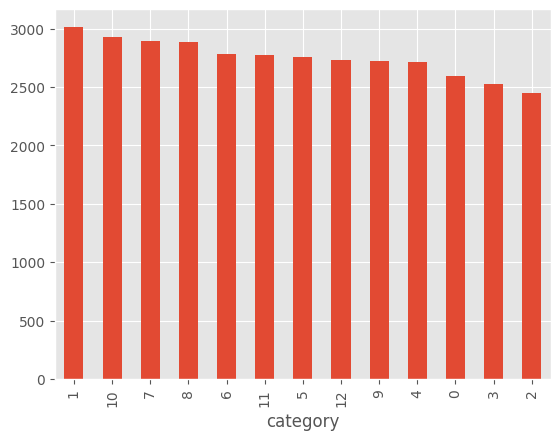

In [ ]:
data['category'].value_counts().plot(kind = 'bar')

Видим, что классы целевой переменной практически сбалансированные

In [ ]:
category_counts = sorted(data['category'].value_counts())
for idx, count in enumerate(category_counts):
    print(f"({idx}) {count}")

(0) 2452
(1) 2524
(2) 2593
(3) 2713
(4) 2720
(5) 2730
(6) 2758
(7) 2773
(8) 2785
(9) 2885
(10) 2897
(11) 2929
(12) 3015


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35774 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       35774 non-null  int64 
 1   category  35774 non-null  int64 
 2   text      35774 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## Лемматизация текста

In [ ]:
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для лемматизации текста
def lemmatize_text(text):
    tokens = word_tokenize(text)  # Токенизация текста
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Лемматизация токенов
    return ' '.join(lemmatized_tokens)

# Применение лемматизации к столбцу 'text'
data['text_lemmatized'] = data['text'].apply(lemmatize_text)

In [ ]:
data

,oid,category,text,text_lemmatized
0,365271984,12,Волшебные фото Виктория Поплавская ЕвгенияМедв...,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,5,Возвращение в подземелье Треша 33 Эйфория тупо...,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,6,Лучшие чешские вратари – Доминик Доминатор Гаш...,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,3,Rtokenoid Warhammer40k валрак решил нас подкор...,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,7,Шестеркин затаскивает Рейнджерс в финал Восточ...,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...,...
38735,910636962,1,8 битная буря снова накрыла пикселями автомоби...,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,1,Ира Сидоркова объясняет как сказалась на ее ма...,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,10,24 я ракетка мира хорват Марин Чилич обыграл и...,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,11,Стал известен календарь мужской сборной России...,Стал известен календарь мужской сборной России...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35774 entries, 0 to 38739
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   oid              35774 non-null  int64 
 1   category         35774 non-null  int64 
 2   text             35774 non-null  object
 3   text_lemmatized  35774 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [ ]:
data.describe()

,oid,category
count,3.577400e+04,35774.000000
mean,5.021517e+08,6.072427
std,2.830081e+08,3.729150
min,1.659400e+04,0.000000
25%,2.667564e+08,3.000000
50%,5.068296e+08,6.000000
75%,7.423103e+08,9.000000
max,9.997113e+08,12.000000


## Удаление стоп-слов и пунктуации из текстов

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words and word not in punctuation_set]
    return filtered_tokens

# Предварительная обработка данных
data['text_lemmatized'] = data['text_lemmatized'].apply(preprocess_text)

In [ ]:
data

,oid,category,text,text_lemmatized
0,365271984,12,Волшебные фото Виктория Поплавская ЕвгенияМедв...,"[волшебные, фото, виктория, поплавская, евгени..."
1,503385563,5,Возвращение в подземелье Треша 33 Эйфория тупо...,"[возвращение, подземелье, треша, 33, эйфория, ..."
2,146016084,6,Лучшие чешские вратари – Доминик Доминатор Гаш...,"[лучшие, чешские, вратари, доминик, доминатор,..."
3,933865449,3,Rtokenoid Warhammer40k валрак решил нас подкор...,"[rtokenoid, warhammer40k, валрак, решил, подко..."
4,713550145,7,Шестеркин затаскивает Рейнджерс в финал Восточ...,"[шестеркин, затаскивает, рейнджерс, финал, вос..."
...,...,...,...,...
38735,910636962,1,8 битная буря снова накрыла пикселями автомоби...,"[8, битная, буря, снова, накрыла, пикселями, а..."
38736,669736851,1,Ира Сидоркова объясняет как сказалась на ее ма...,"[ира, сидоркова, объясняет, сказалась, машине,..."
38737,558919241,10,24 я ракетка мира хорват Марин Чилич обыграл и...,"[24, ракетка, мира, хорват, марин, чилич, обыг..."
38738,776944963,11,Стал известен календарь мужской сборной России...,"[стал, известен, календарь, мужской, сборной, ..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35774 entries, 0 to 38739
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   oid              35774 non-null  int64 
 1   category         35774 non-null  int64 
 2   text             35774 non-null  object
 3   text_lemmatized  35774 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [ ]:
data.describe()

,oid,category
count,3.577400e+04,35774.000000
mean,5.021517e+08,6.072427
std,2.830081e+08,3.729150
min,1.659400e+04,0.000000
25%,2.667564e+08,3.000000
50%,5.068296e+08,6.000000
75%,7.423103e+08,9.000000
max,9.997113e+08,12.000000


# Model Train and Predict

### №1 Функция для подсчета метрик качества модели многоклассовой классификации

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def calculate_classification_metrics(y_true, y_pred, y_pred_proba, model_name, threshold=None):
    """
    Функция для подсчета метрик качества модели классификации.

    Аргументы:
    y_true -- истинные значения целевой переменной
    y_pred -- предсказанные значения целевой переменной
    y_pred_proba -- вероятности предсказаний (для бинарной классификации)
    model_name -- название модели
    threshold -- порог для классификации (по умолчанию None)

    Возвращает словарь с названиями метрик и их значениями.
    """
    metrics = {'Model': model_name}

    if len(np.unique(y_true)) == 2:  # Бинарная классификация
        if threshold is not None:
            y_pred_thresholded = (y_pred_proba[:, 1] >= threshold).astype(int)
            metrics['Accuracy'] = accuracy_score(y_true, y_pred_thresholded)
            metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba[:, 1])
            metrics['Precision'] = precision_score(y_true, y_pred_thresholded)
            metrics['Recall'] = recall_score(y_true, y_pred_thresholded)
            metrics['F1 Score'] = f1_score(y_true, y_pred_thresholded)
            metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred_thresholded).tolist()
        else:
            metrics['Accuracy'] = accuracy_score(y_true, y_pred)
            metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba[:, 1])
            metrics['Precision'] = precision_score(y_true, y_pred)
            metrics['Recall'] = recall_score(y_true, y_pred)
            metrics['F1 Score'] = f1_score(y_true, y_pred)
            metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    else:  # Многоклассовая классификация
        metrics['Accuracy'] = accuracy_score(y_true, y_pred)
        metrics['Precision (Micro)'] = precision_score(y_true, y_pred, average='micro')
        metrics['Recall (Micro)'] = recall_score(y_true, y_pred, average='micro')
        metrics['F1 Score (Micro)'] = f1_score(y_true, y_pred, average='micro')
        metrics['Precision (Macro)'] = precision_score(y_true, y_pred, average='macro')
        metrics['Recall (Macro)'] = recall_score(y_true, y_pred, average='macro')
        metrics['F1 Score (Macro)'] = f1_score(y_true, y_pred, average='macro')
        #metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()

    return metrics

### №2 Функция для определения оптимального количества соседей

In [ ]:
def find_optimal_neighbors(X, y, max_neighbors):
    # Разделение данных на тренировочный и тестовый наборы
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Создание модели KNeighborsClassifier
    knn = KNeighborsClassifier()

    # Параметры для GridSearchCV
    param_grid = {'n_neighbors': range(1, max_neighbors + 1)}

    # GridSearchCV для подбора оптимального количества соседей
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Оптимальное количество соседей
    optimal_neighbors = grid_search.best_params_['n_neighbors']

    return optimal_neighbors

### №3 Функция для определения оптимального количества соседей и весов соседей

In [ ]:
def find_optimal_neighbors_and_weights(X, y, max_neighbors):
    # Разделение данных на тренировочный и тестовый наборы
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Создание модели KNeighborsClassifier
    knn = KNeighborsClassifier()

    # Параметры для GridSearchCV
    param_grid = {
        'n_neighbors': range(1, max_neighbors + 1),
        'weights': ['uniform', 'distance']  # Перебор двух вариантов весов соседей
    }

    # GridSearchCV для подбора оптимального количества соседей и весов
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Оптимальные параметры
    optimal_neighbors = grid_search.best_params_

    return optimal_neighbors

## Токенизация и векторизация текста с использованием Word2Vec

In [ ]:
sentences = data['text_lemmatized']  # Загружаем уже лемматизированные тексты
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

from sklearn.utils import shuffle
def texts_to_vectors(texts):
    vectors = []
    for text in texts:
        vector_sum = 0
        for word in text:
            if word in word2vec_model.wv:
                vector_sum += word2vec_model.wv[word]
        vectors.append(vector_sum)
    return vectors

X = texts_to_vectors(sentences)
y = data['category']

from imblearn.over_sampling import RandomOverSampler
# Создаем объект RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Применяем oversampling к данным для сбалансирования классов
X, y = oversampler.fit_resample(X, y)

# Перемешивание данных
X, y = shuffle(X, y)

# Вывод X и y на экран
print("X (признаки):")
print(X[:5])  # Вывод 5 элементов признаков
print("\n")
print("y (целевая переменная):")
print(y[:5])  # Вывод первых 5 элементов целевой переменной

X (признаки):
[[-35.61732864379883, 139.9535369873047, -17.110063552856445, -77.50729370117188, -43.13169860839844, -14.053290367126465, 37.02912902832031, 85.7935562133789, -61.46599578857422, -45.57280731201172, 12.448444366455078, -55.06504440307617, 73.96676635742188, -24.55317497253418, 17.517614364624023, -66.18920135498047, 82.73297119140625, -58.201637268066406, -13.756256103515625, -77.39830017089844, -79.40409851074219, -13.759344100952148, 175.58287048339844, 51.10748291015625, -106.58918762207031, 67.75457763671875, 18.259267807006836, -68.18716430664062, 34.19606399536133, 25.032564163208008, 84.22327423095703, -46.256839752197266, 0.794603705406189, -65.93506622314453, -38.890899658203125, 68.64844512939453, -52.18487548828125, -17.81328582763672, -57.23411178588867, -20.574920654296875, 30.536972045898438, 48.88090133666992, -41.409793853759766, 39.62263107299805, 42.36370086669922, 13.11889934539795, 31.161762237548828, -107.33863830566406, 6.252691745758057, -18.231042

<Axes: xlabel='category'>

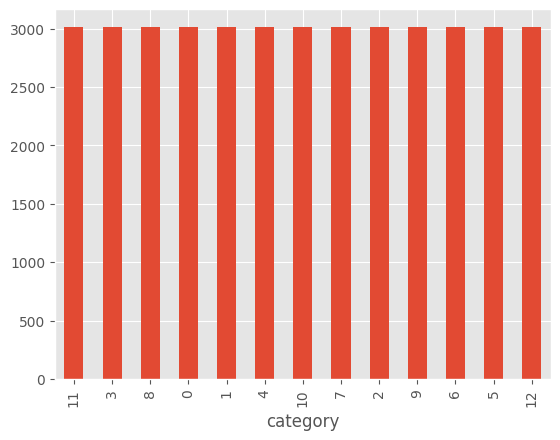

In [ ]:
y.value_counts().plot(kind = 'bar')

Видим, что теперь классы целевой переменной полностью сбалансированные

## Разбиение на контроль и масштабирование данных

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Построение модели многоклассовой классификации (метод K ближайших соседей - KNN)

## Поиск оптимального количества соседей

In [ ]:
optimal_neighbors = find_optimal_neighbors(X_train, y_train, max_neighbors = 25)

In [ ]:
print("Optimal number of neighbors:", optimal_neighbors)

Optimal number of neighbors: 1


### Модель №1 - Метрика euclidean

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_neighbors, p=2, metric = 'euclidean')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_1 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass KNN №1')
print("Метрики качества модели:")
for metric, value in metrics_1.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass KNN №1
Accuracy: 0.5473912488837862
Precision (Micro): 0.5473912488837862
Recall (Micro): 0.5473912488837862
F1 Score (Micro): 0.5473912488837862
Precision (Macro): 0.5455951538529002
Recall (Macro): 0.5455737813797261
F1 Score (Macro): 0.5450787434145452


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       613
           1       0.51      0.46      0.48       601
           2       0.51      0.54      0.52       605
           3       0.70      0.75      0.72       626
           4       0.42      0.39      0.40       604
           5       0.52      0.53      0.52       612
           6       0.35      0.36      0.35       585
           7       0.43      0.44      0.43       585
           8       0.42      0.41      0.42       589
           9       0.68      0.73      0.70       597
          10       0.75      0.67      0.71       616
          11       0.55      0.56      0.55       602
          12       0.51      0.53      0.52       604

    accuracy                           0.55      7839
   macro avg       0.55      0.55      0.55      7839
weighted avg       0.55      0.55      0.55      7839



### Модель №2 - Метрика manhattan

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_neighbors, p=1, metric='manhattan')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_2 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass KNN №2')
print("Метрики качества модели:")
for metric, value in metrics_2.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass KNN №2
Accuracy: 0.5453501722158438
Precision (Micro): 0.5453501722158438
Recall (Micro): 0.5453501722158438
F1 Score (Micro): 0.5453501722158438
Precision (Macro): 0.5437648498188197
Recall (Macro): 0.5435367224612788
F1 Score (Macro): 0.5432398477494721


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       613
           1       0.50      0.47      0.49       601
           2       0.50      0.54      0.52       605
           3       0.70      0.74      0.72       626
           4       0.42      0.40      0.41       604
           5       0.51      0.52      0.52       612
           6       0.34      0.34      0.34       585
           7       0.42      0.43      0.43       585
           8       0.44      0.42      0.43       589
           9       0.70      0.73      0.71       597
          10       0.75      0.67      0.71       616
          11       0.55      0.56      0.55       602
          12       0.50      0.51      0.51       604

    accuracy                           0.55      7839
   macro avg       0.54      0.54      0.54      7839
weighted avg       0.55      0.55      0.55      7839



## Построение модели многоклассовой классификации (метод K ближайших соседей - Взвешенный KNN)

## Поиск оптимального количества соседей и весов соседей

In [ ]:
optimal_params = find_optimal_neighbors_and_weights(X_train, y_train, max_neighbors=25)
print("Optimal parameters:", optimal_params)

Optimal parameters: {'n_neighbors': 14, 'weights': 'distance'}


### Модель №3 - Метрика euclidean

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_params['n_neighbors'], weights=optimal_params['weights'], p=2, metric='euclidean')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_3 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass Suspended KNN №3')
print("Метрики качества модели:")
for metric, value in metrics_3.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass Suspended KNN №3
Accuracy: 0.5723944380660798
Precision (Micro): 0.5723944380660798
Recall (Micro): 0.5723944380660798
F1 Score (Micro): 0.5723944380660798
Precision (Macro): 0.5726052660456593
Recall (Macro): 0.5704600131421068
F1 Score (Macro): 0.5694666054255989


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       613
           1       0.61      0.49      0.54       601
           2       0.54      0.58      0.56       605
           3       0.66      0.79      0.72       626
           4       0.44      0.43      0.43       604
           5       0.48      0.53      0.50       612
           6       0.37      0.35      0.36       585
           7       0.47      0.45      0.46       585
           8       0.53      0.47      0.50       589
           9       0.65      0.73      0.69       597
          10       0.82      0.72      0.76       616
          11       0.59      0.54      0.57       602
          12       0.49      0.58      0.53       604

    accuracy                           0.57      7839
   macro avg       0.57      0.57      0.57      7839
weighted avg       0.57      0.57      0.57      7839



### Сохранение лучшей модели на гугл диск

In [ ]:
joblib.dump(neigh, model_path)

['/content/drive/MyDrive/Datasets/neigh_model.pkl']

### Модель №4 - Метрика manhattan

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_params['n_neighbors'], weights=optimal_params['weights'], p=1, metric='manhattan')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_4 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass Suspended KNN №4')
print("Метрики качества модели:")
for metric, value in metrics_4.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass Suspended KNN №4
Accuracy: 0.5620614874346218
Precision (Micro): 0.5620614874346218
Recall (Micro): 0.5620614874346218
F1 Score (Micro): 0.5620614874346218
Precision (Macro): 0.5625947732745245
Recall (Macro): 0.5600461159213161
F1 Score (Macro): 0.5590294445351163


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       613
           1       0.61      0.48      0.54       601
           2       0.54      0.57      0.55       605
           3       0.65      0.79      0.71       626
           4       0.44      0.42      0.43       604
           5       0.47      0.53      0.50       612
           6       0.34      0.33      0.33       585
           7       0.46      0.45      0.45       585
           8       0.51      0.44      0.47       589
           9       0.65      0.72      0.68       597
          10       0.81      0.71      0.76       616
          11       0.59      0.54      0.56       602
          12       0.49      0.57      0.53       604

    accuracy                           0.56      7839
   macro avg       0.56      0.56      0.56      7839
weighted avg       0.56      0.56      0.56      7839



# Model Evaluation

In [ ]:
model_metrics_1_filtered = {key: value for key, value in metrics_1.items() if ((key != 'Model'))}

model_metrics_2_filtered = {key: value for key, value in metrics_2.items() if ((key != 'Model'))}

model_metrics_3_filtered = {key: value for key, value in metrics_3.items() if ((key != 'Model'))}

model_metrics_4_filtered = {key: value for key, value in metrics_4.items() if ((key != 'Model'))}

# Создание DataFrame
df = pd.DataFrame({
    "Model №1": model_metrics_1_filtered,
    "Model №2": model_metrics_2_filtered,
    "Model №3": model_metrics_3_filtered,
    "Model №4": model_metrics_4_filtered
})

# Функция для форматирования значений
def format_values(value):
    if isinstance(value, float):
        return "{:.8f}".format(value)
    else:
        return value

# Применение функции к каждому элементу DataFrame
df = df.applymap(format_values)

# Вывод DataFrame как красивой таблицы
display(df)

,Model №1,Model №2,Model №3,Model №4
Accuracy,0.54739125,0.54535017,0.57239444,0.56206149
Precision (Micro),0.54739125,0.54535017,0.57239444,0.56206149
Recall (Micro),0.54739125,0.54535017,0.57239444,0.56206149
F1 Score (Micro),0.54739125,0.54535017,0.57239444,0.56206149
Precision (Macro),0.54559515,0.54376485,0.57260527,0.56259477
Recall (Macro),0.54557378,0.54353672,0.57046001,0.56004612
F1 Score (Macro),0.54507874,0.54323985,0.56946661,0.55902944


## Вывод: по метрикам качества лучшей моделью оказалась модель №3 - модель многоклассовой классификации (метод K ближайших соседей - Взвешенный KNN) с использованием метрики euclidean

# Предсказание класса одного объекта, выбранного случайным образом из тестовой выборки

### Загрузка лучшей модели для предсказания класса одного объекта

In [ ]:
neigh_best = joblib.load(model_path)

### Выбор случайного объекта из тестовой выборки

In [ ]:
import random
random_index = random.randint(0, len(X_test) - 1)
random_test_sample = X_test[random_index]
random_test_sample

array([ 0.07958079, -0.45487033,  0.3400488 ,  0.47084086,  0.10127204,
        0.19565692, -0.62475866, -0.40923647,  0.39737142,  0.44481234,
       -0.15458634,  0.24431373, -0.30692918, -0.12478105, -0.16943104,
        0.39601671, -0.34126926,  0.35682771, -0.07090423,  0.39592332,
        0.32627716,  0.37284347, -0.4585593 , -0.41490501,  0.54952311,
       -0.43570599, -0.01500027,  0.42180537,  0.0929486 , -0.60258539,
       -0.28524622,  0.38617085,  0.22100636,  0.40137815,  0.5591066 ,
       -0.423512  ,  0.17213845,  0.4829931 ,  0.29900215,  0.28342828,
       -0.2232499 , -0.00991396,  0.33679598, -0.48782195, -0.63692878,
       -0.2588546 , -0.21363904,  0.68224308, -0.24971992, -0.13717275,
       -0.05481397,  0.31121596,  0.24330763,  0.30816882,  0.33922882,
        0.41249555, -0.33179496,  0.50400723,  0.30567793,  0.55300393,
       -0.41614085,  0.56497316, -0.40447663,  0.63265051,  0.47508624,
       -0.50012458,  0.4917655 , -0.30146355,  0.38064002, -0.06

### Истинная метка класса

In [ ]:
true_label = y_test.iloc[random_index]
true_label

5

### Предсказанная метка класса

In [ ]:
neigh_best.predict(random_test_sample.reshape(1, -1))[0]

5

### Метки классов и соответствующие им вероятности

In [ ]:
# Получение вероятностей для каждого класса
predicted_probabilities = neigh_best.predict_proba(random_test_sample.reshape(1, -1))[0]

# Словарь для хранения меток классов и соответствующих вероятностей
class_probs = {}

# Заполнение словаря
for label, prob in zip(neigh_best.classes_, predicted_probabilities):
    class_probs[label] = prob

# Вывод меток классов и соответствующих вероятностей
for label, prob in class_probs.items():
    print(f"Class {label}: {prob}")

Class 0: 0.0
Class 1: 0.13896634735910682
Class 2: 0.0
Class 3: 0.2807249112240669
Class 4: 0.0
Class 5: 0.4243538749641881
Class 6: 0.07323074437449084
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
Class 12: 0.08272412207814739


### Расстояния до  k  соседей в порядке удаления (первый массив — расстояния, второй — идентификаторы объектов)

In [ ]:
neigh_best.kneighbors(random_test_sample.reshape(1, -1))

(array([[1.08276566, 1.12838942, 1.17755447, 1.22313161, 1.26259529,
         1.26641505, 1.28665286, 1.29045601, 1.29155875, 1.30524839,
         1.31686787, 1.31686787, 1.33793084, 1.33793084]]),
 array([[22149, 29411, 29224,  4899, 23061,  3014,  4835, 19090, 21268,
         25519,  7851, 25897,  7957, 18011]]))

# Эксплуатация модели

In [ ]:
# Загрузка модели
neigh_best = joblib.load(model_path)

# Предсказание категории по входному тексту
def predict_category(input_text):
    lemmatized_input = lemmatize_text(input_text)
    input_vector = texts_to_vectors(preprocess_text(lemmatized_input))
    prediction = neigh_best.predict(input_vector)[0]
    category = le.inverse_transform([prediction])[0]
    return category

# Пример использования
input_text = "Венгры скрестили волейбол и настольный теннис. Вам стоит это увидеть Новый вид спорта называется текволи. В Будапеште прошел первый в истории чемпионат мира по текволи teqvotokenoid. Новая игра – гибрид волейбола и настольного тенниса. В нее играют в формате два на два а особенность стола в том что он – изогнутый. Площадка для текволи представляет собой стол окруженный системой линий в форме шестиугольника. Подачи а также атакующие удары в прыжке можно исполнять только из за пределов этих линий а мяч не должен попадать в край стола. После подачи мяч может касаться поверхности стола только один раз а у соперника есть максимум три касания для розыгрыша ответной атаки прием передача удар скидка – все как в других разновидностях волейбола классическом пляжном снежном. Только в текволи нет блока а вместо сетки – прозрачное оргстекло. Правила текволи могут варьироваться в зависимости от турнира но обычно матч идет до победы в двух партиях. В свою очередь партия состоит из двух игр до 8 очков. В каждой из партий у команд есть по одной возможности заказать двухочковый розыгрыш но только если команда еще не набрала 6 очков. Создатели игры убеждены что благодаря своей динамичности она в будущем сможет захватить весь мир. В первом чемпионате мира приняли участие восемь команд причем и мужские и смешанные пары сыграли в одном дивизионе. Им нужно было заплатить вступительный взнос в 50 евро и добраться до Будапешта. Проживание питание транспорт и призовой фонд в 25 тыс долларов предоставили организаторы турнира. Победителями первого турнира стали поляки. rtokenoid мотивация зож текволи TEQVOLY sport спорт"
predicted_category = predict_category(input_text)
print("Предсказанная категория:", predicted_category)

Предсказанная категория: athletics


In [ ]:
#le.inverse_transform([0])

In [ ]:
#data[data['category'] =='athletics']